# Neo4j Weekly Graph Contest #1
Contest:

Use the image below as the only input. The goal is to model it as a graph—whatever that means to you. Get clever, get weird, get visual.

Solution:

Use an LLM (OpenAI: gpt-4o-mini) to extract the product information from the image and create a Neo4j KG in AuraDB.

Author: Peter W. Rose (UCSD)

Created: 2025-03-26

In [1]:
from IPython.display import Image, display
image_url = "https://ci3.googleusercontent.com/meips/ADKq_NZuIpBcIzJzpe1cWvyuOAyl0Z-BlqqT0cm9ZgpQt4co3p4u4qJ8QqgvSiXyVK7rWyk9ktguQbm2gebTfLKhEJNEUT6k4oZhpEEdgiwdC_VrpcKCteA89h_aJskjjPAIZWIEs3nLTw_Vl57LHfOt5l_DCsJ8ArbF64KBTJ3wlp8SDLH225bq7I1kNFXhMCL743-uuzZzluJmNQpZOQ=s0-d-e1-ft#https://us1.discourse-cdn.com/flex021/uploads/neo4jcommunity/optimized/3X/4/f/4f8785a5104c6945ca8a6be0c7fda016996e5f8b_2_495x499.jpeg"
display(Image(url=image_url))

In [2]:
import os
import json
from textwrap import dedent
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

In [3]:
# Load the OPEN_AI_KEY and AuraDB credentials from .env file
ENV_PATH = "../.env"
if not load_dotenv(dotenv_path=ENV_PATH, override=True):
    print("Set the OPEN_AI_KEY and AuraDB credentials in the .env file")

## Extract Product information from the Image

In [4]:
def prompt_gpt_with_image(model, system_message, image_url, response_format={"type": "json_object"}):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": dedent(system_message)},
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": image_url}},
                ]
            }
        ],
        temperature=0,
    )

    return response.choices[0].message.content

In [5]:
model = "gpt-4o-mini"

system_message = """
You are a helpful assistant that analyzes and describes images of products.e
Your task is to identify all distinct products visible in the bowl.

1. Extract the distributer

2. For each unique product, extract the following attributes. Do not nest attributes.
   - Brand, flavor, flavor type, instructions
   - Color(s) of the packaging
   - Shape of the packaging
   - Container type

3. Give the brand and each product a unique identifier (id) and name

4. Detect any relationships between distributor and products and among products, e.g., similar flavor

5. Represent the extracted information in a format suitable for a property graph with nodes and edges named using Neo4j naming conventions. 
Output only pure JSON with no markdown formatting, no triple backticks, or any additional text.

Ensure consistency in predicates and avoid duplication.
"""

# Run the prompt using the image
data = prompt_gpt_with_image(model, system_message, image_url)
data_json = json.loads(data)

In [6]:
data_json

{'distributor': {'name': 'Nestlé', 'id': 'distributor_1'},
 'products': [{'id': 'product_1',
   'name': 'Hazelnut',
   'brand': 'Coffee Mate',
   'flavor': 'Hazelnut',
   'flavor_type': 'Nut',
   'instructions': 'Shake well',
   'color': ['Yellow', 'Red'],
   'shape': 'Cup',
   'container_type': 'Creamer'},
  {'id': 'product_2',
   'name': 'French Vanilla',
   'brand': 'Coffee Mate',
   'flavor': 'French Vanilla',
   'flavor_type': 'Vanilla',
   'instructions': 'Shake well',
   'color': ['Blue', 'White'],
   'shape': 'Cup',
   'container_type': 'Creamer'},
  {'id': 'product_3',
   'name': 'Irish Cream',
   'brand': 'Coffee Mate',
   'flavor': 'Irish Cream',
   'flavor_type': 'Cream',
   'instructions': 'Shake well',
   'color': ['Green', 'White'],
   'shape': 'Cup',
   'container_type': 'Creamer'},
  {'id': 'product_4',
   'name': 'Italian Sweet Cream',
   'brand': 'Coffee Mate',
   'flavor': 'Italian Sweet Cream',
   'flavor_type': 'Cream',
   'instructions': 'Shake well',
   'color':

## Connect to AuraDB
Define your AuraDB credentials in the .env file.

In [7]:
from neo4j import GraphDatabase

NEO4J_URI = os.environ.get("NEO4J_URI")
NEO4J_USERNAME = os.environ.get("NEO4J_USERNAME")
NEO4J_PASSWORD = os.environ.get("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

In [8]:
# Clear all nodes and relationships
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

## Import the data

In [9]:
def import_nodes(tx, nodes, label):
    for node in nodes:
        props = node.copy()
        node_id = props.pop("id")  # Remove 'id' from the map for matching

        cypher = f"""
            MERGE (p:{label} {{id: $id}})
            SET p += $props
        """
        tx.run(cypher, id=node_id, props=props)

In [10]:
with driver.session() as session:
    session.execute_write(import_nodes, data_json["products"], "Product")
    session.execute_write(import_nodes, [data_json["distributor"]], "Distributor")

In [11]:
def import_relationships(tx, relationships):
    for rel in relationships:
        # Dynamically get the relationship type from the data
        rel_type = list(rel.values())[-1].upper()
        # Convert to Neo4j convention
        rel_type = rel_type.replace(" ", "_").upper()

        cypher = f"""
            MATCH (n1{{id: $fromId}})
            MATCH (n2{{id: $toId}})
            MERGE (n1)-[:{rel_type}]->(n2)
        """
        tx.run(cypher, fromId=rel["from"], toId=rel["to"])

In [12]:
with driver.session() as session:
    session.execute_write(import_relationships, data_json["relationships"])

## Verify the Data

In [13]:
with driver.session() as session:
    result = session.run("MATCH (n) RETURN properties(n) AS props")
    data = [record["props"] for record in result]

df = pd.DataFrame(data)
df.fillna("", inplace=True)
df.sort_values("id")

,id,instructions,color,name,flavor,flavor_type,brand,shape,container_type
1,distributor_1,,,Nestlé,,,,,
2,product_1,Shake well,"[Yellow, Red]",Hazelnut,Hazelnut,Nut,Coffee Mate,Cup,Creamer
3,product_2,Shake well,"[Blue, White]",French Vanilla,French Vanilla,Vanilla,Coffee Mate,Cup,Creamer
4,product_3,Shake well,"[Green, White]",Irish Cream,Irish Cream,Cream,Coffee Mate,Cup,Creamer
5,product_4,Shake well,"[Red, White]",Italian Sweet Cream,Italian Sweet Cream,Cream,Coffee Mate,Cup,Creamer
0,product_5,Shake well,"[Brown, White]",Caramel,Caramel,Caramel,Coffee Mate,Cup,Creamer


In [14]:
with driver.session() as session:
    results = session.run("""
        MATCH (n1)-[rel]->(n2)
        RETURN labels(n1)[0] AS node1, n1.name AS name1, type(rel) AS relationship, labels(n2)[0] AS node2, n2.name AS name2
    """)
    records = [record.data() for record in results]

pd.DataFrame(records)

,node1,name1,relationship,node2,name2
0,Distributor,Nestlé,DISTRIBUTES,Product,Caramel
1,Distributor,Nestlé,DISTRIBUTES,Product,Hazelnut
2,Distributor,Nestlé,DISTRIBUTES,Product,French Vanilla
3,Distributor,Nestlé,DISTRIBUTES,Product,Irish Cream
4,Distributor,Nestlé,DISTRIBUTES,Product,Italian Sweet Cream
5,Product,Hazelnut,SIMILAR_FLAVOR,Product,Irish Cream
6,Product,Italian Sweet Cream,SIMILAR_FLAVOR,Product,Irish Cream


In [15]:
driver.close()

## Visualization of the Graph in AuroDB

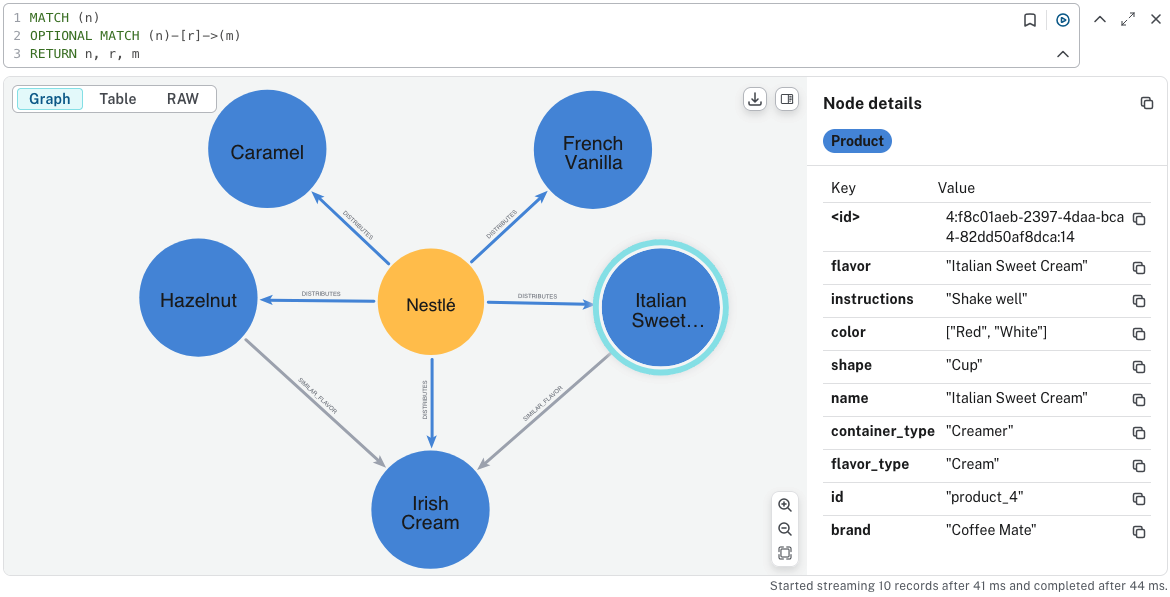

In [17]:
display(Image(filename="../images/contest1_graph.png"))